## ConfLM: Using LLMs and YANG Embeddings for Network Device Configuration
### Version: 2.2.0

#### This notebook demonstrates an approach to network device configuration using text embeddings and YANG data models.

### Introduction: 

* YANG (Yet Another Next Generation) is a data modeling language used to model configuration data, state data, and notifications for network management protocols.
* It provides a hierarchical, structured way to define how network devices should be configured and monitored.
* YANG models serve as contracts between network devices and management systems, enabling standardized configuration across multi-vendor environments.

## Reference: 
* https://en.wikipedia.org/wiki/YANG
* IETF RFC: https://datatracker.ietf.org/doc/html/rfc7950


* Author: Shaji R. Nathan
* Email: shaji.nathan@ipinfusion.com
* Company: IP INFUSION INC.

### Description: 

This project explores the application of natural language processing techniques, specifically text embeddings, to the domain of network configuration management. It creates a system that can:

* Process YANG data models to understand their semantic content
* Match configuration templates to YANG models using vector embeddings
* Generate appropriate router configurations based on parameters and intent
* Support cross-vendor translation of configurations

### Motivation: 
By representing both YANG models and configuration templates in the same embedding space, the system can identify semantic relationships between them, enabling more intelligent configuration generation and reducing the networking expertise barrier for new network engineers.

### Key Features: 

* Extraction of meaningful semantic content from YANG models
* Embedding generation for YANG models and configuration templates
* Similarity analysis between models and templates
* Configuration generation from parameters
* Cross-vendor configuration translation (currently Cisco Systems/Juniper Networks)
* Visualization of embedding relationships

### Installation/Dependencies: 
#### pip install sentence-transformers pyang jinja2 networkx matplotlib pandas

### Usage
Run the notebook cells in sequence to:

* Set up sample YANG models and configuration templates
* Process these files to generate embeddings
* Analyze relationships between YANG models and templates
* Generate sample configurations for different network components
* Visualize the embedding space
* For LLM interaction run ollama  with llama3:8b


### Expected Output
The system generates configurations for:

* Router Ethernet Interface settings
* OSPF routing
* Access Control Lists (ACLs)

For multiple vendors (Cisco and Juniper) using the same parameters.



### Design Notes: 

### Implement 
### YangEmbeddingSystem class, that: 
*Uses sentence-transformers to generate embeddings
*Extracts meaningful content from YANG models (module names, descriptions, and structure)
* Finds the most semantically similar templates for a given YANG model
* Renders configuration templates using appropriate parameters
* Supports cross-vendor configuration generation

### License
This project is licensed under the GNU Affero General Public License v3.0 (AGPLv3) - see below for details.

ConfLM: Using LLMs and YANG Embeddings for Network Device Configuration
Copyright (C) 2025 John Smith, Network Technology Solutions, Inc.
https://www.networktech.ai

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

Contact information:
Email: shaji.nathan@ipinfusion.com

IP INFUSION , Inc.
3979 Freedom Cir #900, 
Santa Clara, CA 95054
United States

### Key AGPL Requirements

* If you modify and distribute this code, you must make your changes available under the AGPL
* If you run this code on a server and allow users to interact with it over a network, you must provide the source code to those users
* All derivative works must be licensed under the AGPL

For the complete license text, visit: https://www.gnu.org/licenses/agpl-3.0.html


In [3]:
# Necessary Imports 

import os
import re
import glob
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import json
import torch
from sentence_transformers import SentenceTransformer
from jinja2 import Template

In [2]:
# Create directories for our files
!mkdir -p yang_files config_templates generated_configs

In [4]:
%%writefile yang_files/interfaces.yang
module interfaces {
  namespace "urn:example:interfaces";
  prefix if;
  
  organization "Example Organization";
  description "YANG model for network interfaces configuration";
  
  revision "2023-01-01" {
    description "Initial revision";
  }

  container interfaces {
    description "Interface configuration parameters";
    
    list interface {
      key "name";
      description "List of interfaces";
      
      leaf name {
        type string;
        description "Interface name";
      }
      
      leaf description {
        type string;
        description "Interface description";
      }
      
      leaf enabled {
        type boolean;
        description "Interface operational state";
        default "true";
      }
      
      leaf mtu {
        type uint16 {
          range "68..9000";
        }
        description "Maximum transmission unit";
        default 1500;
      }
      
      container ipv4 {
        description "IPv4 configuration";
        
        leaf enabled {
          type boolean;
          description "Enable IPv4";
          default "true";
        }
        
        list address {
          key "ip";
          description "IPv4 addresses";
          
          leaf ip {
            type string;
            description "IPv4 address";
          }
          
          leaf prefix-length {
            type uint8 {
              range "0..32";
            }
            description "IPv4 prefix length";
          }
        }
      }
    }
  }
}

Writing yang_files/interfaces.yang


In [5]:
%%writefile yang_files/routing.yang
module routing {
  namespace "urn:example:routing";
  prefix rt;
  
  organization "Example Organization";
  description "YANG model for routing protocols configuration";
  
  revision "2023-01-01" {
    description "Initial revision";
  }

  container routing {
    description "Routing configuration parameters";
    
    container ospf {
      description "OSPF routing protocol configuration";
      
      leaf enabled {
        type boolean;
        description "Enable OSPF routing";
        default "false";
      }
      
      leaf router-id {
        type string;
        description "OSPF router identifier";
      }
      
      list area {
        key "area-id";
        description "OSPF area configuration";
        
        leaf area-id {
          type uint32;
          description "Area identifier";
        }
        
        leaf area-type {
          type enumeration {
            enum "normal";
            enum "stub";
            enum "nssa";
          }
          description "Area type";
          default "normal";
        }
        
        list interface {
          key "name";
          description "OSPF interface configuration";
          
          leaf name {
            type string;
            description "Interface name";
          }
          
          leaf priority {
            type uint8;
            description "OSPF router priority";
            default 1;
          }
          
          leaf hello-interval {
            type uint16;
            description "OSPF hello interval in seconds";
            default 10;
          }
          
          leaf dead-interval {
            type uint16;
            description "OSPF dead interval in seconds";
            default 40;
          }
        }
      }
    }
    
    container bgp {
      description "BGP routing protocol configuration";
      
      leaf enabled {
        type boolean;
        description "Enable BGP routing";
        default "false";
      }
      
      leaf local-as {
        type uint32;
        description "Local autonomous system number";
      }
      
      list neighbor {
        key "address";
        description "BGP neighbors";
        
        leaf address {
          type string;
          description "Neighbor IP address";
        }
        
        leaf remote-as {
          type uint32;
          description "Remote autonomous system number";
        }
        
        leaf description {
          type string;
          description "Neighbor description";
        }
      }
    }
  }
}


Writing yang_files/routing.yang


In [6]:
%%writefile yang_files/acl.yang
module acl {
  namespace "urn:example:acl";
  prefix acl;
  
  organization "Example Organization";
  description "YANG model for access control lists";
  
  revision "2023-01-01" {
    description "Initial revision";
  }

  container acls {
    description "Access control list configuration";
    
    list acl {
      key "name";
      description "List of ACLs";
      
      leaf name {
        type string;
        description "ACL name";
      }
      
      leaf type {
        type enumeration {
          enum "ipv4";
          enum "ipv6";
          enum "mac";
        }
        description "ACL type";
        default "ipv4";
      }
      
      list entry {
        key "sequence";
        description "ACL entries";
        
        leaf sequence {
          type uint32;
          description "Sequence number";
        }
        
        leaf action {
          type enumeration {
            enum "permit";
            enum "deny";
          }
          description "Action to take on match";
        }
        
        leaf source-address {
          type string;
          description "Source IP address or prefix";
        }
        
        leaf destination-address {
          type string;
          description "Destination IP address or prefix";
        }
        
        leaf protocol {
          type string;
          description "IP protocol";
        }
        
        leaf source-port {
          type string;
          description "Source port or range";
        }
        
        leaf destination-port {
          type string;
          description "Destination port or range";
        }
      }
    }
  }
}

Writing yang_files/acl.yang


## 2. Create Configuration Templates

### Let's create some router configuration templates for different vendors

In [7]:
%%writefile config_templates/cisco_interface.j2
interface {{ interface_name }}
 description {{ description }}
 {% if not enabled %}shutdown{% else %}no shutdown{% endif %}
 {% if mtu %}mtu {{ mtu }}{% endif %}
 {% if ipv4_enabled %}
 {% for address in ipv4_addresses %}
 ip address {{ address.ip }} {{ address.netmask }}
 {% endfor %}
 {% endif %}

Writing config_templates/cisco_interface.j2


In [8]:
%%writefile config_templates/juniper_interface.j2
interfaces {
    {{ interface_name }} {
        description "{{ description }}";
        {% if mtu %}mtu {{ mtu }};{% endif %}
        {% if not enabled %}disable;{% endif %}
        {% if ipv4_enabled %}
        {% for address in ipv4_addresses %}
        unit 0 {
            family inet {
                address {{ address.ip }}/{{ address.prefix_length }};
            }
        }
        {% endfor %}
        {% endif %}
    }
}

Writing config_templates/juniper_interface.j2


In [9]:
%%writefile config_templates/cisco_ospf.j2
router ospf {{ process_id }}
 router-id {{ router_id }}
 {% for area in areas %}
 {% for interface in area.interfaces %}
 network {{ interface.network }} {{ interface.wildcard }} area {{ area.area_id }}
 {% endfor %}
 {% if area.area_type != "normal" %}
 area {{ area.area_id }} {{ area.area_type }}
 {% endif %}
 {% endfor %}

Writing config_templates/cisco_ospf.j2


In [10]:
%%writefile config_templates/juniper_ospf.j2
protocols {
    ospf {
        router-id {{ router_id }};
        {% for area in areas %}
        area {{ area.area_id }} {
            {% for interface in area.interfaces %}
            interface {{ interface.name }} {
                {% if interface.priority != 1 %}priority {{ interface.priority }};{% endif %}
                {% if interface.hello_interval != 10 %}hello-interval {{ interface.hello_interval }};{% endif %}
                {% if interface.dead_interval != 40 %}dead-interval {{ interface.dead_interval }};{% endif %}
            }
            {% endfor %}
        }
        {% endfor %}
    }
}

Writing config_templates/juniper_ospf.j2


In [11]:
%%writefile config_templates/cisco_acl.j2
ip access-list {{ acl_type }} {{ acl_name }}
 {% for entry in entries %}
 {{ entry.sequence }} {{ entry.action }} {{ entry.protocol }} {{ entry.source_address }} {{ entry.destination_address }}{% if entry.source_port %} eq {{ entry.source_port }}{% endif %}{% if entry.destination_port %} eq {{ entry.destination_port }}{% endif %}
 {% endfor %}

Writing config_templates/cisco_acl.j2


In [12]:
%%writefile config_templates/juniper_acl.j2
firewall {
    family inet {
        filter {{ acl_name }} {
            {% for entry in entries %}
            term {{ entry.sequence }} {
                from {
                    source-address {
                        {{ entry.source_address }};
                    }
                    destination-address {
                        {{ entry.destination_address }};
                    }
                    protocol {{ entry.protocol }};
                    {% if entry.source_port %}
                    source-port {{ entry.source_port }};
                    {% endif %}
                    {% if entry.destination_port %}
                    destination-port {{ entry.destination_port }};
                    {% endif %}
                }
                then {
                    {% if entry.action == "permit" %}
                    accept;
                    {% else %}
                    discard;
                    {% endif %}
                }
            }
            {% endfor %}
        }
    }
}

Writing config_templates/juniper_acl.j2


## 3. YANG File Processing and Embedding Generation

In [18]:
# This class implements the YANG embedding system

class YangEmbeddingSystem:
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        """Initialize the YANG embedding system with a specified embedding model."""
        self.model = SentenceTransformer(model_name)
        self.yang_embeddings = {}  # Maps YANG module names to embeddings
        self.yang_contents = {}    # Maps YANG module names to their content
        self.yang_extracted = {}   # Maps YANG module names to extracted text
        self.template_embeddings = {}  # Maps template names to embeddings
        self.template_contents = {}    # Maps template names to their content
        
    def extract_yang_content(self, yang_content):
        """Extract meaningful content from a YANG file for embedding."""
        # Extract module name
        module_match = re.search(r'module\s+(\S+)\s+{', yang_content)
        module_name = module_match.group(1) if module_match else "unknown"
        
        # Extract descriptions
        descriptions = re.findall(r'description\s+"([^"]+)"', yang_content)
        
        # Extract leaf names, container names, list names
        leafs = re.findall(r'leaf\s+(\S+)\s+{', yang_content)
        containers = re.findall(r'container\s+(\S+)\s+{', yang_content)
        lists = re.findall(r'list\s+(\S+)\s+{', yang_content)
        
        # Extract types
        types = re.findall(r'type\s+(\S+)', yang_content)
        
        # Combine all extracted elements
        extracted_text = f"Module: {module_name}. "
        
        if descriptions:
            extracted_text += "Descriptions: " + " ".join(descriptions) + ". "
        
        if leafs:
            extracted_text += "Leafs: " + ", ".join(leafs) + ". "
        
        if containers:
            extracted_text += "Containers: " + ", ".join(containers) + ". "
        
        if lists:
            extracted_text += "Lists: " + ", ".join(lists) + ". "
        
        if types:
            extracted_text += "Types: " + ", ".join(types) + "."
        
        return extracted_text
    
    def process_yang_file(self, file_path):
        """Process a YANG file and generate its embedding."""
        # Read YANG file
        with open(file_path, 'r') as f:
            yang_content = f.read()
        
        # Get the module name from the file name
        module_name = os.path.basename(file_path).replace('.yang', '')
        
        # Extract meaningful content for embedding
        extracted_text = self.extract_yang_content(yang_content)
        
        # Generate embedding
        embedding = self.model.encode(extracted_text)
        
        # Store in our dictionaries
        self.yang_embeddings[module_name] = embedding
        self.yang_contents[module_name] = yang_content
        self.yang_extracted[module_name] = extracted_text
        
        return module_name, embedding, extracted_text
    
    def process_template_file(self, file_path):
        """Process a template file and generate its embedding."""
        # Read template file
        with open(file_path, 'r') as f:
            template_content = f.read()
        
        # Get template name from file name
        template_name = os.path.basename(file_path)
        
        # Generate embedding
        embedding = self.model.encode(template_content)
        
        # Store in our dictionaries
        self.template_embeddings[template_name] = embedding
        self.template_contents[template_name] = template_content
        
        return template_name, embedding
    
    def find_similar_templates(self, yang_module_name, top_n=3):
        """Find templates that are most similar to a YANG module."""
        if yang_module_name not in self.yang_embeddings:
            raise ValueError(f"YANG module {yang_module_name} not found in the system")
        
        yang_embedding = self.yang_embeddings[yang_module_name]
        
        similarities = []
        for template_name, template_embedding in self.template_embeddings.items():
            similarity = cosine_similarity([yang_embedding], [template_embedding])[0][0]
            similarities.append((template_name, similarity))
        
        # Sort by similarity (highest first)
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        return similarities[:top_n]
    
    def generate_configuration(self, template_name, parameters):
        """Generate configuration using a template and parameters."""
        if template_name not in self.template_contents:
            raise ValueError(f"Template {template_name} not found in the system")
        
        template_content = self.template_contents[template_name]
        template = Template(template_content)
        
        try:
            configuration = template.render(**parameters)
            return configuration
        except Exception as e:
            raise ValueError(f"Error rendering template: {e}")
    
    def find_best_template_for_parameters(self, parameters, yang_module_name=None, top_n=1):
        """Find the best template for a set of parameters, optionally considering YANG module."""
        # Create a text representation of the parameters
        param_text = json.dumps(parameters)
        param_embedding = self.model.encode(param_text)
        
        # If YANG module is provided, blend its embedding with parameters
        if yang_module_name and yang_module_name in self.yang_embeddings:
            yang_embedding = self.yang_embeddings[yang_module_name]
            # Blend 70% parameters and 30% YANG module
            blended_embedding = 0.7 * param_embedding + 0.3 * yang_embedding
            query_embedding = blended_embedding
        else:
            query_embedding = param_embedding
        
        # Find similar templates
        similarities = []
        for template_name, template_embedding in self.template_embeddings.items():
            similarity = cosine_similarity([query_embedding], [template_embedding])[0][0]
            similarities.append((template_name, similarity))
        
        # Sort by similarity (highest first)
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        return similarities[:top_n]
    
    def generate_config_from_parameters(self, parameters, yang_module_name=None):
        """Generate the best configuration for the given parameters."""
        best_templates = self.find_best_template_for_parameters(parameters, yang_module_name)
        
        if not best_templates:
            raise ValueError("No suitable templates found")
        
        template_name, similarity = best_templates[0]
        configuration = self.generate_configuration(template_name, parameters)
        
        return configuration, template_name, similarity      
       
    def visualize_embeddings(self, highlight_module=None):
        """Visualize embeddings of YANG modules and templates using PCA."""
        ## need to clean up displaying, this will do for now
        try:
            # Collect all embeddings
            names = list(self.yang_embeddings.keys()) + list(self.template_embeddings.keys())
            embeddings = list(self.yang_embeddings.values()) + list(self.template_embeddings.values())
            types = ["yang"] * len(self.yang_embeddings) + ["template"] * len(self.template_embeddings)
            
            if not embeddings:
                print("No embeddings available for visualization.")
                # Return empty DataFrame and None to maintain return structure
                return pd.DataFrame(), None
            
            # Print the number of samples to understand our dataset size
            n_samples = len(embeddings)
            print(f"Visualizing {n_samples} embeddings")
            
            # Convert list of embeddings to a numpy array
            embeddings_array = np.vstack(embeddings)
            
            # Use PCA instead of t-SNE for small datasets
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            reduced_embeddings = pca.fit_transform(embeddings_array)
            
            # Create a DataFrame for easier plotting
            df = pd.DataFrame({
                'name': names,
                'type': types,
                'x': reduced_embeddings[:, 0],
                'y': reduced_embeddings[:, 1]
            })
            
            # Create the plot
            plt.figure(figsize=(10, 8))
            
            # Plot YANG modules
            yang_df = df[df['type'] == 'yang']
            plt.scatter(yang_df['x'], yang_df['y'], c='blue', label='YANG Modules', alpha=0.7, s=100)
            
            # Plot templates
            template_df = df[df['type'] == 'template']
            plt.scatter(template_df['x'], template_df['y'], c='green', label='Templates', alpha=0.7, s=100, marker='s')
            
            # Highlight specific module if requested
            if highlight_module and highlight_module in self.yang_embeddings:
                highlight_idx = names.index(highlight_module)
                plt.scatter(reduced_embeddings[highlight_idx, 0], reduced_embeddings[highlight_idx, 1], 
                          c='red', s=200, label=f'Highlighted: {highlight_module}', edgecolors='black')
            
            # Add labels to all points
            for i, txt in enumerate(names):
                plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), 
                            fontsize=8, alpha=0.8)
            
            plt.title('PCA Visualization of YANG Modules and Templates')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            return df, reduced_embeddings
        
        except Exception as e:
            # Print the error but don't crash
            print(f"Error in visualization: {str(e)}")
            # Return empty DataFrame and None to maintain return structure
            return pd.DataFrame(), None

 
    # LLM interaction
    def add_llm_assistant(self, llm_assistant):
        """Add LLM assistant capabilities to the YANG embedding system."""
        self.llm = llm_assistant
    
    def analyze_yang_with_llm(self, yang_module_name):
        """Use LLM to analyze a YANG model."""
        if not hasattr(self, 'llm'):
            raise ValueError("LLM assistant not added. Use add_llm_assistant() first.")
        
        if yang_module_name not in self.yang_contents:
            raise ValueError(f"YANG module {yang_module_name} not found in the system")
        
        yang_content = self.yang_contents[yang_module_name]
        return self.llm.analyze_yang_model(yang_content)
    
    def explain_template_match(self, yang_module_name, template_name):
        """Explain why a template matches a YANG model."""
        if not hasattr(self, 'llm'):
            raise ValueError("LLM assistant not added. Use add_llm_assistant() first.")
        
        if yang_module_name not in self.yang_embeddings:
            raise ValueError(f"YANG module {yang_module_name} not found in the system")
        
        if template_name not in self.template_embeddings:
            raise ValueError(f"Template {template_name} not found in the system")
        
        # Calculate similarity
        yang_embedding = self.yang_embeddings[yang_module_name]
        template_embedding = self.template_embeddings[template_name]
        similarity = cosine_similarity([yang_embedding], [template_embedding])[0][0]
        
        return self.llm.explain_embedding_similarity(yang_module_name, template_name, similarity)
        #return df, reduced_embeddings,self.llm.explain_embedding_similarity(yang_module_name, template_name, similarity)
   
    

## 4. Initialize Our System and Process Files

In [19]:

# Initialize the YANG embedding system
yang_system = YangEmbeddingSystem()

# Process YANG files
print("Processing YANG files...")
yang_files = glob.glob('yang_files/*.yang')
for yang_file in yang_files:
    module_name, _, extracted = yang_system.process_yang_file(yang_file)
    print(f"Processed {module_name}: {extracted[:100]}...")

# Process template files
print("\nProcessing template files...")
template_files = glob.glob('config_templates/*.j2')
for template_file in template_files:
    template_name, _ = yang_system.process_template_file(template_file)
    print(f"Processed template: {template_name}")

Processing YANG files...
Processed acl: Module: acl. Descriptions: YANG model for access control lists Initial revision Access control list ...
Processed interfaces: Module: interfaces. Descriptions: YANG model for network interfaces configuration Initial revision I...
Processed routing: Module: routing. Descriptions: YANG model for routing protocols configuration Initial revision Routi...

Processing template files...
Processed template: cisco_acl.j2
Processed template: cisco_interface.j2
Processed template: cisco_ospf.j2
Processed template: juniper_acl.j2
Processed template: juniper_interface.j2
Processed template: juniper_ospf.j2


## 5. Analyze the Relationships Between YANG Models and Templates


Similarity between YANG modules and templates:

Top templates for acl:
  cisco_acl.j2: 0.6195
  juniper_acl.j2: 0.4732
  cisco_interface.j2: 0.3076

Top templates for interfaces:
  juniper_interface.j2: 0.5314
  cisco_interface.j2: 0.5193
  cisco_acl.j2: 0.3880

Top templates for routing:
  juniper_ospf.j2: 0.5131
  cisco_ospf.j2: 0.3844
  juniper_interface.j2: 0.3515


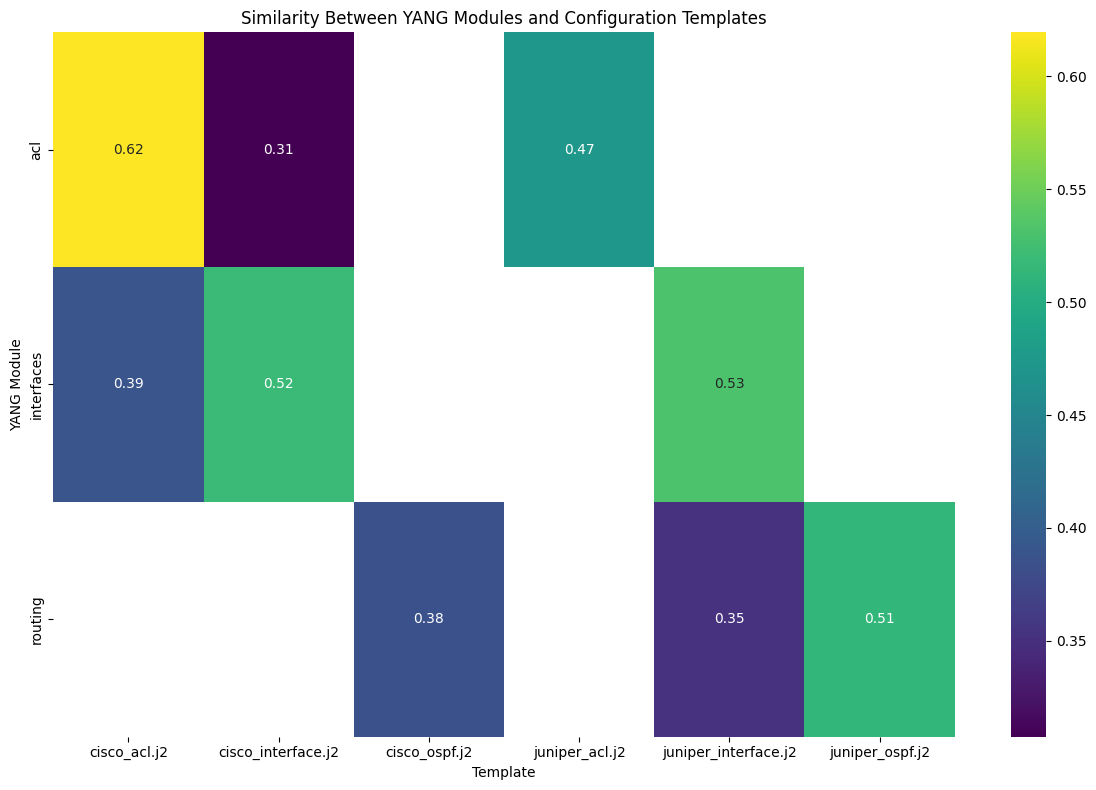


Visualizing embeddings...
Visualizing 9 embeddings


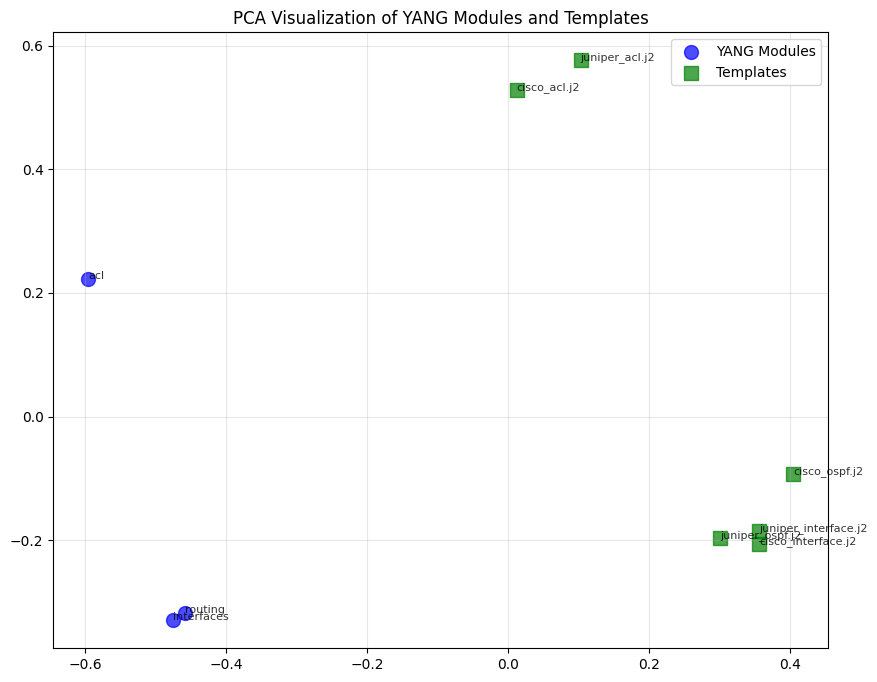

In [20]:
# Display similarity between YANG modules and templates
print("\nSimilarity between YANG modules and templates:")
similarity_data = []

for module_name in yang_system.yang_embeddings:
    similar_templates = yang_system.find_similar_templates(module_name)
    print(f"\nTop templates for {module_name}:")
    for template_name, similarity in similar_templates:
        print(f"  {template_name}: {similarity:.4f}")
        similarity_data.append((module_name, template_name, similarity))

# Create a heatmap of similarities
df_similarity = pd.DataFrame(similarity_data, columns=['YANG Module', 'Template', 'Similarity'])
pivot_similarity = df_similarity.pivot(index='YANG Module', columns='Template', values='Similarity')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_similarity, annot=True, cmap='viridis', fmt='.2f')
plt.title('Similarity Between YANG Modules and Configuration Templates')
plt.tight_layout()
plt.show()

# Visualize the embeddings using t-SNE
print("\nVisualizing embeddings...")
embedding_df, _ = yang_system.visualize_embeddings()


## 6. Generate Router Configurations

In [21]:
# We can now generate some configurations based on our YANG models

# Gigabit Ethernet Interface configuration parameters
interface_params = {
    'interface_name': 'GigabitEthernet0/0/0',
    'description': 'Connection to Core Router',
    'enabled': True,
    'mtu': 9000,
    'ipv4_enabled': True,
    'ipv4_addresses': [
        {'ip': '192.168.1.1', 'netmask': '255.255.255.0', 'prefix_length': 24}
    ]
}

# OSPF routing  configuration parameters
ospf_params = {
    'process_id': 100,
    'router_id': '10.0.0.1',
    'areas': [
        {
            'area_id': 0,
            'area_type': 'normal',
            'interfaces': [
                {'name': 'GigabitEthernet0/0/0', 'network': '192.168.1.0', 'wildcard': '0.0.0.255', 
                 'priority': 1, 'hello_interval': 10, 'dead_interval': 40}
            ]
        },
        {
            'area_id': 1,
            'area_type': 'stub',
            'interfaces': [
                {'name': 'GigabitEthernet0/0/1', 'network': '10.1.1.0', 'wildcard': '0.0.0.255',
                 'priority': 2, 'hello_interval': 5, 'dead_interval': 20}
            ]
        }
    ]
}

# Protocol Access Control List configuration parameters
acl_params = {
    'acl_name': 'INBOUND_FILTER',
    'acl_type': 'extended',
    'entries': [
        {
            'sequence': 10,
            'action': 'permit',
            'protocol': 'tcp',
            'source_address': 'any',
            'destination_address': '192.168.1.0 0.0.0.255',
            'destination_port': '80'
        },
        {
            'sequence': 20,
            'action': 'permit',
            'protocol': 'tcp',
            'source_address': 'any',
            'destination_address': '192.168.1.0 0.0.0.255',
            'destination_port': '443'
        },
        {
            'sequence': 100,
            'action': 'deny',
            'protocol': 'ip',
            'source_address': 'any',
            'destination_address': 'any'
        }
    ]
}

# Generate configurations using the best matching templates
print("\nGenerating configurations...")

# Interface configuration
interface_config, template, similarity = yang_system.generate_config_from_parameters(
    interface_params, 'interfaces')
print(f"\nGenerated interface configuration using {template} (similarity: {similarity:.4f}):")
print(interface_config)

# OSPF routing configuration
ospf_config, template, similarity = yang_system.generate_config_from_parameters(
    ospf_params, 'routing')
print(f"\nGenerated OSPF configuration using {template} (similarity: {similarity:.4f}):")
print(ospf_config)

# ACL configuration
acl_config, template, similarity = yang_system.generate_config_from_parameters(
    acl_params, 'acl')
print(f"\nGenerated ACL configuration using {template} (similarity: {similarity:.4f}):")
print(acl_config)

# Save the generated configurations
with open('generated_configs/interface_config.txt', 'w') as f:
    f.write(interface_config)

with open('generated_configs/ospf_config.txt', 'w') as f:
    f.write(ospf_config)

with open('generated_configs/acl_config.txt', 'w') as f:
    f.write(acl_config)



Generating configurations...

Generated interface configuration using juniper_interface.j2 (similarity: 0.7131):
interfaces {
    GigabitEthernet0/0/0 {
        description "Connection to Core Router";
        mtu 9000;
        
        
        
        unit 0 {
            family inet {
                address 192.168.1.1/24;
            }
        }
        
        
    }
}

Generated OSPF configuration using juniper_ospf.j2 (similarity: 0.7057):
protocols {
    ospf {
        router-id 10.0.0.1;
        
        area 0 {
            
            interface GigabitEthernet0/0/0 {
                
                
                
            }
            
        }
        
        area 1 {
            
            interface GigabitEthernet0/0/1 {
                priority 2;
                hello-interval 5;
                dead-interval 20;
            }
            
        }
        
    }
}

Generated ACL configuration using cisco_acl.j2 (similarity: 0.7411):
ip access-list ext

## 7. Evaluate Cross-Vendor Translation

In [22]:

# We can now try generating the same configuration for different vendor's switching equipment (Cisco Systems and Juniper Networks routers)
# We'll use the same parameters but find the best template for each vendor

# Define vendor prefixes
vendors = {
    'cisco': 'cisco_',
    'juniper': 'juniper_'
}

print("\nCross-vendor configuration generation:")

for vendor, prefix in vendors.items():
    print(f"\n{vendor.upper()} Configurations:")
    
    # Filter templates by vendor
    vendor_templates = {name: emb for name, emb in yang_system.template_embeddings.items() 
                       if name.startswith(prefix)}
    
    # Skip if no templates for this vendor
    if not vendor_templates:
        print(f"No templates available for {vendor}")
        continue
    
    # Temporarily backup the full template list
    full_templates = yang_system.template_embeddings.copy()
    full_contents = yang_system.template_contents.copy()
    
    # Replace with only vendor templates
    yang_system.template_embeddings = vendor_templates
    yang_system.template_contents = {name: yang_system.template_contents[name] 
                                    for name in vendor_templates}
    
    try:
        # Generate configurations for this vendor
        for config_type, params, yang_module in [
            ('interface', interface_params, 'interfaces'),
            ('ospf', ospf_params, 'routing'),
            ('acl', acl_params, 'acl')
        ]:
            try:
                config, template, similarity = yang_system.generate_config_from_parameters(
                    params, yang_module)
                print(f"\n{config_type.upper()} Configuration ({template}, similarity: {similarity:.4f}):")
                print(config)
                
                # Save to file
                with open(f'generated_configs/{vendor}_{config_type}_config.txt', 'w') as f:
                    f.write(config)
            except Exception as e:
                print(f"Error generating {config_type} config for {vendor}: {e}")
    finally:
        # Restore the full template list
        yang_system.template_embeddings = full_templates
        yang_system.template_contents = full_contents


Cross-vendor configuration generation:

CISCO Configurations:

INTERFACE Configuration (cisco_interface.j2, similarity: 0.6709):
interface GigabitEthernet0/0/0
 description Connection to Core Router
 no shutdown
 mtu 9000
 
 
 ip address 192.168.1.1 255.255.255.0
 
 

OSPF Configuration (cisco_ospf.j2, similarity: 0.6614):
router ospf 100
 router-id 10.0.0.1
 
 
 network 192.168.1.0 0.0.0.255 area 0
 
 
 
 
 network 10.1.1.0 0.0.0.255 area 1
 
 
 area 1 stub
 
 

ACL Configuration (cisco_acl.j2, similarity: 0.7411):
ip access-list extended INBOUND_FILTER
 
 10 permit tcp any 192.168.1.0 0.0.0.255 eq 80
 
 20 permit tcp any 192.168.1.0 0.0.0.255 eq 443
 
 100 deny ip any any
 

JUNIPER Configurations:

INTERFACE Configuration (juniper_interface.j2, similarity: 0.7131):
interfaces {
    GigabitEthernet0/0/0 {
        description "Connection to Core Router";
        mtu 9000;
        
        
        
        unit 0 {
            family inet {
                address 192.168.1.1/24;
   

## 8. LLM Interaction 

In [23]:
import requests
import json

In [24]:
class OllamaAssistant:
    def __init__(self, model="llama3:8b"):
        """Initialize the Ollama assistant with specified model."""
        self.model = model
        self.api_url = "http://localhost:11434/api/generate"
        
    def generate(self, prompt, system_prompt=None, temperature=0.7):
        """Generate a response using the local Ollama model."""
        headers = {"Content-Type": "application/json"}
        
        payload = {
            "model": self.model,
            "prompt": prompt,
            "temperature": temperature,
            "stream": False
        }
        
        if system_prompt:
            payload["system"] = system_prompt
            
        try:
            response = requests.post(self.api_url, headers=headers, data=json.dumps(payload))
            response.raise_for_status()
            return response.json()["response"]
        except Exception as e:
            return f"Error generating response: {str(e)}"
    
    def analyze_yang_model(self, yang_content):
        """Analyze a YANG model and extract key components."""
        system_prompt = """
        You are a network automation expert specializing in YANG models.
        Analyze the YANG model provided and extract key information including:
        1. Module name and namespace
        2. Key containers, lists, and leaf nodes
        3. Data types and constraints
        4. Primary network function this model represents
        Be technically precise and focus on the most important elements.
        """
        
        prompt = f"Please analyze this YANG model and extract key information:\n\n```\n{yang_content}\n```"
        return self.generate(prompt, system_prompt)
    
    def suggest_configuration(self, yang_model_name, parameters):
        """Suggest a configuration based on a YANG model and parameters."""
        system_prompt = """
        You are a network configuration assistant. 
        Given a YANG model name and configuration parameters, suggest appropriate
        router configurations that would implement the intent.
        Provide examples for both Cisco and Juniper syntax if possible.
        """
        
        parameters_str = json.dumps(parameters, indent=2)
        prompt = f"Suggest router configurations for YANG model '{yang_model_name}' with these parameters:\n\n{parameters_str}"
        return self.generate(prompt, system_prompt)
    
    def explain_embedding_similarity(self, yang_model, template, similarity_score):
        """Explain why a template matches a YANG model with the given similarity score."""
        system_prompt = """
        You are an expert in NLP and network configurations.
        Explain why a particular configuration template might semantically match a YANG model,
        considering the similarity score provided.
        """
        
        prompt = f"""
        YANG model: {yang_model}
        Template: {template}
        Similarity score: {similarity_score}
        
        Please explain why these might be semantically related and what this similarity score indicates.
        """
        return self.generate(prompt, system_prompt)

 

## 9. Create a Network Admin Dialog Interface

In [25]:
class NetworkAdminDialog:
    def __init__(self, yang_system, llm_assistant):
        """Initialize the dialog interface with YANG system and LLM assistant."""
        self.yang_system = yang_system
        self.llm = llm_assistant
        self.conversation_history = []
        self.current_parameters = {}
        self.current_yang_model = None
        
    def process_query(self, query):
        """Process a natural language query from a network administrator."""
        # Add to conversation history
        self.conversation_history.append({"role": "user", "content": query})
        
        # Use LLM to analyze the intent
        intent_analysis = self._analyze_intent(query)
        
        # Handle different intents
        if intent_analysis["intent"] == "configuration_request":
            response = self._handle_configuration_request(intent_analysis)
        elif intent_analysis["intent"] == "parameter_update":
            response = self._handle_parameter_update(intent_analysis)
        elif intent_analysis["intent"] == "information_request":
            response = self._handle_information_request(intent_analysis)
        else:
            response = "I'm not sure how to help with that. Could you ask about a specific network configuration?"
        
        # Add response to history
        self.conversation_history.append({"role": "assistant", "content": response})
        return response
    
    
    def _analyze_intent(self, query):
        """Use LLM to analyze the intent of the query."""
        system_prompt = """
        You are a network intent analyzer. Given a network administrator's query,
        determine their intent and extract relevant parameters.
        
        Always respond with a valid JSON object with the following structure:
        {
            "intent": "configuration_request",
            "yang_model_type": "interfaces",
            "parameters": {
                "interface_name": "extracted interface name",
                "description": "extracted description if any",
                "ipv4_addresses": [{"ip": "extracted IP", "netmask": "converted netmask", "prefix_length": "extracted prefix"}]
            },
            "missing_parameters": []
        }
        
        For interface configurations:
        - Set intent to "configuration_request"
        - Set yang_model_type to "interfaces"
        - Extract interface_name, IP addresses, descriptions
        - Convert CIDR notation (like /24) to proper netmask and prefix_length
        
        For routing configurations:
        - Set yang_model_type to "routing"
        - Extract protocol, router-id, areas, networks
        
        For ACL configurations:
        - Set yang_model_type to "acl"
        - Extract rules, sources, destinations, actions
    
        Wrap all string values in double quotes in your JSON.
        """
        
        # Include relevant context from conversation history
        context = "\n".join([f"{item['role']}: {item['content']}" for item in self.conversation_history[-3:] if len(self.conversation_history) > 0])
        prompt = f"Context of conversation:\n{context}\n\nCurrent query: {query}\n\nAnalyze the intent and extract parameters."
        
        try:
            result = self.llm.generate(prompt, system_prompt)
            print(f"DEBUG - LLM response: {result}")  # Add this for debugging
            
            # Try to find and extract JSON from the response
            import re
            json_match = re.search(r'(\{.*\})', result.replace('\n', ' '), re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
                return json.loads(json_str)
            
            # If we couldn't find JSON with regex, try loading the whole thing
            try:
                return json.loads(result)
            except:
                pass
            
            # Fallback to basic intent detection for common network configurations
            # This will run if Ollama fails or returns non-JSON
            if "interface" in query.lower() and ("ip" in query.lower() or "address" in query.lower()):
                # Extract interface name using regex
                interface_match = re.search(r'([A-Za-z]+\d+\/\d+(?:\/\d+)?)', query)
                interface_name = interface_match.group(1) if interface_match else "Unknown"
            
                # Extract IP address using regex
                ip_match = re.search(r'(\d+\.\d+\.\d+\.\d+)(?:\/(\d+))?', query)
                ip = ip_match.group(1) if ip_match else "192.168.1.1"
                prefix = ip_match.group(2) if ip_match and ip_match.group(2) else "24"
                
                # Convert prefix to netmask
                import ipaddress
                netmask = str(ipaddress.IPv4Network(f"0.0.0.0/{prefix}").netmask)
                
                # Extract description
                desc_match = re.search(r'for\s+the\s+(.+?)(?:\.|\s*$)', query)
                description = desc_match.group(1) if desc_match else "Network Connection"
                
                return {
                    "intent": "configuration_request",
                    "yang_model_type": "interfaces",
                    "parameters": {
                        "interface_name": interface_name,
                        "description": description,
                        "enabled": True,
                        "ipv4_enabled": True,
                        "ipv4_addresses": [
                            {"ip": ip, "netmask": netmask, "prefix_length": int(prefix)}
                        ]
                    },
                    "missing_parameters": []
                }
            
        except Exception as e:
            print(f"DEBUG - Error in intent analysis: {str(e)}")
            
        # If all else fails, return a default analysis (not None)
        return {
            "intent": "other",
            "yang_model_type": "unknown",
            "parameters": {},
            "missing_parameters": []
        }
        
    def _handle_configuration_request(self, intent_analysis):
        """Handle a request for generating a configuration."""
        yang_model_type = intent_analysis["yang_model_type"]
        
        # Update current state
        self.current_yang_model = yang_model_type
        self.current_parameters.update(intent_analysis["parameters"])
        
        # Debug print
        print(f"DEBUG - Parameters for config generation: {self.current_parameters}")
        
        # Check if we have enough parameters - with defensive programming
        if "missing_parameters" in intent_analysis and intent_analysis["missing_parameters"]:
            missing = ", ".join(intent_analysis["missing_parameters"])
            return f"I need some additional information to generate the {yang_model_type} configuration. Could you provide: {missing}?"
        
        def _handle_parameter_update(self, intent_analysis):
            """Handle updates to configuration parameters."""
            # Update parameters
            self.current_parameters.update(intent_analysis["parameters"])
            
            # Acknowledge the update
            params_str = ", ".join([f"{k}={v}" for k, v in intent_analysis["parameters"].items()])
            response = f"I've updated the parameters: {params_str}."
            
            # Check if we can now generate a configuration
            if self.current_yang_model and not intent_analysis["missing_parameters"]:
                response += "\n\nWould you like me to generate the configuration now?"
            
            return response
    
    def _handle_information_request(self, intent_analysis):
        """Handle requests for information about YANG models or parameters."""
        yang_model_type = intent_analysis["yang_model_type"]
        
        if yang_model_type != "unknown" and yang_model_type in self.yang_system.yang_extracted:
            extracted_info = self.yang_system.yang_extracted[yang_model_type]
            analysis = self.yang_system.analyze_yang_with_llm(yang_model_type) if hasattr(self.yang_system, 'analyze_yang_with_llm') else "Analysis not available."
            
            return f"Information about the {yang_model_type} YANG model:\n\n{extracted_info}\n\nAnalysis:\n{analysis}"
        else:
            available_models = ", ".join(self.yang_system.yang_embeddings.keys())
            return f"I can provide information about these YANG models: {available_models}. Which one are you interested in?"
    
    def start_dialog(self):
        """Start an interactive dialog in the notebook."""
        from IPython.display import display, clear_output
        import ipywidgets as widgets
        
        # Create widgets
        output = widgets.Output()
        text_input = widgets.Text(placeholder="Type your request here...")
        send_button = widgets.Button(description="Send")
        
        # Define button click behavior
        def on_send_button_clicked(b):
            query = text_input.value
            if not query.strip():
                return
                
            with output:
                clear_output()
                # Display conversation history
                for message in self.conversation_history:
                    if message["role"] == "user":
                        print(f"🧑‍💻 Network Admin: {message['content']}")
                    else:
                        print(f"🤖 Assistant: {message['content']}")
                
                # Process and display new response
                print(f"🧑‍💻 Network Admin: {query}")
                response = self.process_query(query)
                print(f"🤖 Assistant: {response}")
            
            text_input.value = ""
        
        send_button.on_click(on_send_button_clicked)
        
        # Layout
        input_box = widgets.HBox([text_input, send_button])
        display(widgets.VBox([output, input_box]))
        
        # Display initial message
        with output:
            print("🤖 Assistant: Hello! I'm your network configuration assistant. What kind of configuration do you need today?")

In [26]:
# First, create the Ollama assistant
llm_assistant = OllamaAssistant()

# Then, create the dialog interface
admin_dialog = NetworkAdminDialog(yang_system, llm_assistant)

# Start the interactive dialog
admin_dialog.start_dialog()

## 8. Conclusion and Next Steps

### The configuration generation system was able to implement the following:

1. Processes YANG models to understand their structure and semantics
2. Maps configuration templates to YANG models using embeddings
3. Selects the most appropriate template based on parameters and YANG model
4. Generates router configurations for different vendors
5. Enables cross-vendor configuration generation
6. Chat interface for interactive configuration generation via llm

## Next Steps :
1. Implementing more sophistication in  YANG parsing (example: pyang library)
2. Adding validation of generated configurations against YANG models
3. Incorporating network intent understanding
4. Building a training dataset of YANG models and known-good configurations
5. Creating a fine-tuned embedding model specific to network configurations
6. Integration with Anomaly detection module (developed in Session 1, 2 and 3) and network controller for auto-configuration